# Plot the individual contributions of different molecules 

Tom Schad | 27 July 2023 

In [32]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob
import sys
from py4cats import *  
import py4cats

import matplotlib.pyplot as plt
%matplotlib widget 
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'
plt.rcParams['font.sans-serif'] = "Comic Sans MS"
plt.rcParams['font.family'] = "serif"
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from scipy import ndimage

from tqdm.auto import trange
import multiprocessing

In [35]:
hitran_data_file = './HITRAN_VIS_IR/65e912c9.par'
os.makedirs('./telluric_synAtlas/',exist_ok=True)

In [34]:
def vac2air(wave_vac):
    """ 
    Converts wavelengths from vacuum to air-equivalent 
    Morton (2000, ApJ. Suppl., 130, 3043); IAU standard

    wave_vac is given in Angstroms
    
    """
    wave_vac = np.atleast_1d(wave_vac)
    wave_air = np.copy(wave_vac)
    ww  = (wave_vac >= 2000) 
    sigma2 = (1e4 / wave_vac[ww])**2 
    n = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wave_air[ww] = wave_vac[ww] / n
    return wave_air

In [18]:
def air2vac(wave_air): 
    """ Converts wavelengths from air-equivalent to vacuum
    Ciddor (1996) formula
    Adapted from airtovac.pro
    wave_air  :: angstroms 
    
    https://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
    
    """
    wave_air = np.atleast_1d(wave_air)
    wave_vac = np.copy(wave_air)
    ww  = (wave_air >= 2000) 
    sigma2 = (1e4 / wave_air[ww])**2 
    n = 1. + 8.336624212083e-5 + 0.02408926869968 / (130.1065924522 - sigma2) + \
        0.0001599740894897 / (38.92568793293 - sigma2)
    wave_vac[ww] = wave_air[ww] * n
    return wave_vac
    

In [19]:
## Wavenumber range of 350 to 5000 nm 
1e7/(air2vac(np.array([3500.,50000.]))/10.)
## 2546 to 2536

array([28563.25629993,  1999.45477389])

## Load atmospheres 

In [20]:
atm_midLatWinter = py4cats.atmRead('./py4cats/data/atmos/50/midlatitudeWinter.xy')
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy')

 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p, T, air   and 7 molecules on 50 levels


In [21]:
550000. # g/cm/s^2 
550000./1000.*100  # Pas
550000./1000.*100 / 101325 # atm

0.5428077966938071

In [22]:
## z, pressure in atm, temp
for n in range(10): 
    print(n,' ',atm_midLatWinter['z'][n]/1e5,atm_midLatWinter['p'][n]/1000.*100./101325.,atm_midLatWinter['T'][n])

0   0.0 1.004687885516901 272.2
1   1.0 0.8855662472242783 268.7
2   2.0 0.7793733037256353 265.2
3   3.0 0.6847273624475697 261.7
4   4.0 0.6001480384900074 255.7
5   5.0 0.5243523316062175 249.7
6   6.0 0.4566493955094991 243.7
7   7.0 0.39634838391315075 237.7
8   8.0 0.34275845053047127 231.7
9   9.0 0.29538613372810263 225.7


Text(0.5, 0, 'Height [km]')

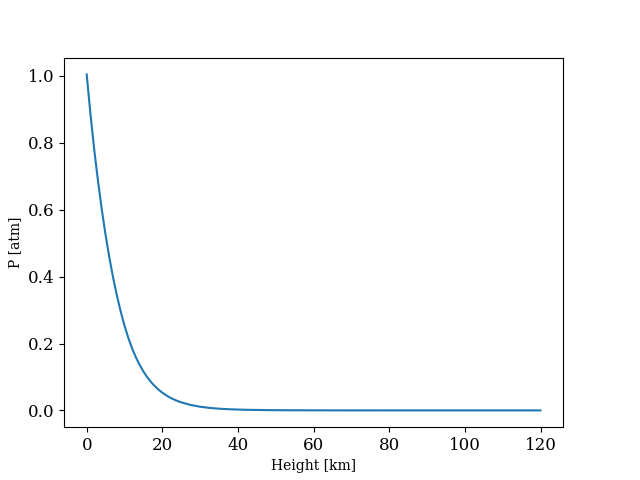

In [23]:
plt.figure()
plt.plot(atm_midLatWinter['z']/1e5,atm_midLatWinter['p']/1000.*100./101325.)
plt.ylabel("P [atm]")
plt.xlabel("Height [km]")

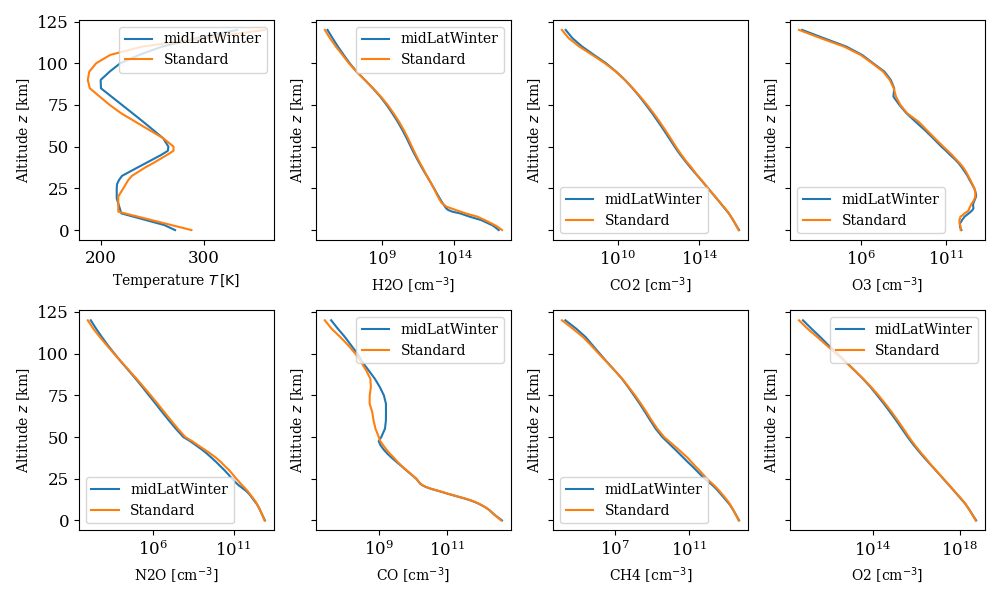

In [24]:
fig,ax = plt.subplots(2,4,figsize = (10,6),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
atmPlot(atm_midLatWinter,label = 'midLatWinter')
atmPlot(atm_standard,label = 'Standard')
ax[0].legend()

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    atmPlot(atm_midLatWinter,main_mol[n-1],label = 'midLatWinter')
    atmPlot(atm_standard,main_mol[n-1],label = 'Standard')
    ax[n].set_xscale('log')
    ax[n].legend()

fig.tight_layout()

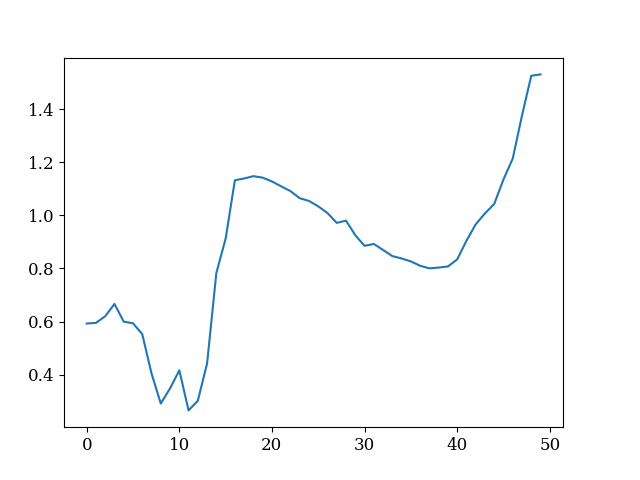

In [25]:
plt.figure()
plt.plot(atm_midLatWinter['H2O']/atm_standard['H2O'])

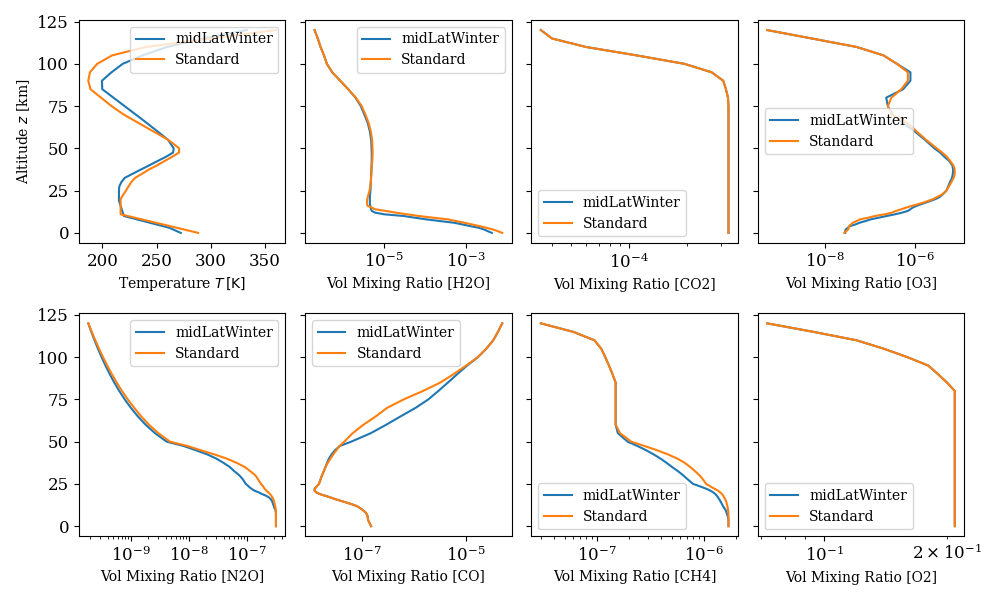

In [26]:
fig,ax = plt.subplots(2,4,figsize = (10,6),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
atmPlot(atm_midLatWinter,label = 'midLatWinter')
atmPlot(atm_standard,label = 'Standard')
ax[0].legend()

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    plt.plot(vmr(atm_midLatWinter,main_mol[n-1]),atm_midLatWinter['z']/1e5,label = 'midLatWinter')
    plt.plot(vmr(atm_standard,main_mol[n-1]),atm_standard['z']/1e5,label = 'Standard')
    plt.xscale('log')
    plt.xlabel('Vol Mixing Ratio ['+main_mol[n-1] + ']')
    ax[n].legend()

fig.tight_layout()

## Get vertical column densities [molec / cm**2 ] 

In [27]:
print(f"Vertical column density in tropics (full atmosphere): {py4cats.vcd(atm_midLatWinter,'H2O',zMin = 0.0)}") 
print(f"Vertical column density in tropics (above 3km): {py4cats.vcd(atm_midLatWinter,'H2O',zMin = 3.0)}") 
print(f"Vertical column density in US standard (full atmosphere): {py4cats.vcd(atm_standard,'H2O',zMin = 0.0)}") 
print(f"Vertical column density in US standard  (above 3km): {py4cats.vcd(atm_standard,'H2O',zMin = 3.0)}") 

Vertical column density in tropics (full atmosphere): 2.8906793192152994e+22
Vertical column density in tropics (above 3km): 6.689164304859456e+21
Vertical column density in US standard (full atmosphere): 4.808953629516041e+22
Vertical column density in US standard  (above 3km): 1.1474288295160396e+22


###  Calculate precipitable water
* mass density of water is ~ 0.9998 g/cm**3
* average molar mass of water is 18.01528 g/mol
* Na = 6.022e23

In [28]:
# V = rho * h * Na / M 
rho = 0.9998  # g/cm**3
Na = 6.022e23 # molec / mole 
M = 18.01528 # g / mole 
V = py4cats.vcd(atm_midLatWinter,'H2O',zMin = 3.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [midLatWinter]')
V = py4cats.vcd(atm_standard,'H2O',zMin = 3.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [standard]')

2.001515678726055  millimeters PWV [midLatWinter]
3.4333089872381177  millimeters PWV [standard]


In [29]:
print(' Column Mixing Ratios: ')
for mol in main_mol: 
    print(mol,': ',py4cats.cmr(atm_standard,mol),' ',py4cats.cmr(atm_midLatWinter,mol))

 Column Mixing Ratios: 
H2O :  0.002229410417070704   0.0013339356157016577
CO2 :  0.0003299997842732906   0.00032999976609065525
O3 :  4.3066488345722325e-07   4.7050180472127663e-07
N2O :  3.069927242334716e-07   2.985580417295545e-07
CO :  1.1090503302790937e-07   1.1193728422709478e-07
CH4 :  1.6475201901221172e-06   1.5905201894530973e-06
O2 :  0.20899988385262291   0.2089998775533233


## 1st run example

In [30]:
wv0,wv1 = 8540,8550
wv0,wv1 = 10825,10845
wv0,wv1 = 5890,5900

wn1,wn0 = 1e7/(air2vac(np.array([wv0,wv1]))/10.)
print(wv0,wv1)
print(wn1,wn0)

dictOfLineLists = higstract(hitran_data_file,(wn0,wn1),molecule = 'main',verbose = False)
print(dictOfLineLists.keys())

## limit the lines to those of some minimum strength
strMin = 1e-28
keys = dictOfLineLists.keys()
keys = [key for key in keys]
cnt =0
for mol in keys: 
    wg = dictOfLineLists[mol]['S'] >= strMin
    dictOfLineLists[mol] = dictOfLineLists[mol][wg]
    cnt += len(dictOfLineLists[mol])
    if len(dictOfLineLists[mol]) == 0: 
        dictOfLineLists.pop(mol, None)
print(' number of lines:',cnt)


atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3) ################## 3 KILOMETERS FOR HALEAKALA - DKIST 
V = vcd(atm_standard,'H2O')
h = V /rho/Na * M * 10  ## millimeters
pwv_standard = h 
print(h,' millimeters PWV [standard]')

## get absorption cross sections
xssDict = lbl2xs(dictOfLineLists, atm_standard['p'], atm_standard['T'],(wn0,wn1),verbose = False)

plt.figure()

## loop over ppwv and airmass 
for ppwv in (1,2,3,4,5,6,8,10,):
    
    ## changes in precipitable water 
    atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3)
    atm_standard['H2O'] *= ppwv / pwv_standard
    V = vcd(atm_standard,'H2O')

    ## absorption coefficients
    absCoList = xs2ac(atm_standard, xssDict) 
    ## Optical depth
    dodList = ac2dod(absCoList,verbose=False)

    for airmass in 1,1.5,2,3:
        ## change the airmass for a slant geometry 
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]*airmass  ## airmass    
        tod = dod2tod(dodList)  ## total od 

        ## back -correct the list to reapply a scaling
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]/airmass  ## airmass    
    
        plt.plot(vac2air(1e7/tod.grid()*10),np.exp(-tod),lw = 1)

        wvair = vac2air(1e7/tod.grid()*10)

5890 5900
16975.04668137837 16946.28029147602


NameError: name 'hitr' is not defined

In [ ]:
from IPython.utils import io

def genTelluricAtlas(argin): 

    wv0,wv1 = argin 
    wn1,wn0 = 1e7/(air2vac(np.array([wv0,wv1]))/10.)
    print(' started: ',wv0,wv1)
    
    with io.capture_output() as captured:
    
        wv0,wv1 = argin 
        wn1,wn0 = 1e7/(air2vac(np.array([wv0,wv1]))/10.)
        print(wv0,wv1)
        print(wn1,wn0)
        
        dictOfLineLists = higstract('./HITRAN/VIS_IR/64e18314.par',(wn0,wn1),molecule = 'main',verbose = False)
        print(dictOfLineLists.keys())
        
        ## limit the lines to those of some minimum strength
        strMin = 1e-28
        keys = dictOfLineLists.keys()
        keys = [key for key in keys]
        cnt =0
        for mol in keys: 
            wg = dictOfLineLists[mol]['S'] >= strMin
            dictOfLineLists[mol] = dictOfLineLists[mol][wg]
            cnt += len(dictOfLineLists[mol])
            if len(dictOfLineLists[mol]) == 0: 
                dictOfLineLists.pop(mol, None)
        print(' number of lines:',cnt)
        
        
        atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3) ################## 3 KILOMETERS FOR HALEAKALA - DKIST 
        V = vcd(atm_standard,'H2O')
        h = V /rho/Na * M * 10  ## millimeters
        pwv_standard = h 
        print(h,' millimeters PWV [standard]')
        
        ## get absorption cross sections
        xssDict = lbl2xs(dictOfLineLists, atm_standard['p'], atm_standard['T'],(wn0,wn1),verbose = False)
        
        #plt.figure()
        
        ## loop over ppwv and airmass 
        for ppwv in (1,2,3,4,5,6,8,10,):
            
            ## changes in precipitable water 
            atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy',zBoA  = 3) ################## 3 KILOMETERS FOR HALEAKALA - DKIST 
            atm_standard['H2O'] *= ppwv / pwv_standard
            V = vcd(atm_standard,'H2O')
        
            ## absorption coefficients
            absCoList = xs2ac(atm_standard, xssDict) 
            ## Optical depth
            dodList = ac2dod(absCoList,verbose=False)
    
            tod = dod2tod(dodList)  ## total od 
            wvair = vac2air(1e7/tod.grid()*10)
    
            savdir = './telluric_synAtlas/'
            savname = savdir + 'pycats_hitran_'+str(int(np.ceil(wvair.min()))) + '_' + str(int(np.floor(wvair.max()))) + '_wvair.npy'
            #print(savname)
            np.save(savname,wvair) 
            
            ## different airmasses 
            for airmass in 1,1.5,2,3,4,:
                ## change the airmass for a slant geometry 
                for n in range(len(dodList)): 
                    dodList[n] = dodList[n]*airmass  ## airmass    
                tod = dod2tod(dodList)  ## total od 
    
                ## back -correct the list to reapply a scaling
                for n in range(len(dodList)): 
                    dodList[n] = dodList[n]/airmass  ## airmass    
    
                #plt.plot(vac2air(1e7/tod.grid()*10),np.exp(-tod),lw = 1)
        
                ## SAVE THE DATA 
                
                savname = savdir + 'pycats_hitran_'+str(int(np.ceil(wvair.min()))) + '_' + str(int(np.floor(wvair.max()))) + \
                                        '_airmass_' + str(airmass) + '_ppwv_' + str(ppwv) + '.npy'
                #print(savname)
                np.save(savname,np.exp(-tod))

    return wv0,wv1

In [ ]:
#genTelluricAtlas((5850,5900))
#genTelluricAtlas((5900,5950))

In [ ]:
## I want to cover 350 to 5000 nm in 50 nm chunks with 4 nm overlap? 
## I want to cover 350 to 5000 nm in 30 nm chunks with 4 nm overlap? 

In [ ]:
wv0s = np.arange(155)*30 + (350-2.)
wv1s = np.arange(155)*30 + (350-2.) + 32
wv0s *= 10.
wv1s *= 10.
print(wv1s[-1])
for n in trange(5): 
    print(wv0s[n],wv1s[n])

In [ ]:
#genTelluricAtlas((3480,3800))

In [ ]:
if 1: 
    ncpus = 75
    p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
    arg_array = []
    for n in range(len(wv0s)): 
        arg_array.append((wv0s[n],wv1s[n]))
    
    rs    = p.imap(genTelluricAtlas,arg_array)
    p.close()
    
    from tqdm import tqdm
    nargs = len(arg_array)
    pbar = tqdm(total=nargs,position = 0, leave = True)
    for i,res in enumerate(rs):
        wv0,wv1 = res 
        print(' done: ',wv0,wv1)

In [ ]:
## 1 million resolution wv vector
wv = []
wv.append(3500.)
while wv[-1] < 50000: 
    wv.append( wv[-1] + wv[-1]/1000000)
wv = np.array(wv)

trans_final = np.zeros((len(wv),8,5))
                  

In [ ]:
for pidx,ppwv in enumerate((1,2,3,4,5,6,8,10,)):
    for aidx,airmass in enumerate((1,1.5,2,3,4,)):
        print(pidx,aidx)
        f1 = glob.glob('./telluric_synAtlas/*airmass_' + str(airmass) + '_ppwv_' + str(ppwv) + '.npy')
        f1.sort()

        wvair_all = []
        trans_all = []
        for f in f1:
            wvf = os.path.dirname(f) + os.sep +  os.path.basename(f).split('air')[0] +'wvair.npy'
            wvair = np.load(wvf)
            trans = np.load(f)
            wg = (wvair>(wvair.min()+9.)) *  (wvair<(wvair.max()-9.))
            wvair_all.append(wvair[wg])
            trans_all.append(trans[wg])
        
        wvair_all = np.hstack(wvair_all)
        trans_all = np.hstack(trans_all)

        swv = np.argsort(wvair_all)
        wvair_all = wvair_all[swv]
        trans_all = trans_all[swv]

        tr = np.interp(wv,wvair_all,trans_all)

        trans_final[:,pidx,aidx] = tr 

In [ ]:
print(wv.nbytes/1024./1024.,trans_final.nbytes/1024./1024.)
wv = wv.astype(np.float32)
trans_final = trans_final.astype(np.float32)
print(wv.nbytes/1024./1024.,trans_final.nbytes/1024./1024.)

In [ ]:
np.save('./wvair_final.npy',wv)
np.save('./trans_final.npy',trans_final)

In [ ]:
plt.figure()
wp = (wv > 6302-5) * (wv < 6302 + 5)
#wp = (wv > 8542-5) * (wv < 8542 + 5)
#wp = (wv > 14300-15) * (wv < 14300 + 15)

for pidx,ppwv in enumerate((1,2,3,4,5,6,8,10,)):
    for aidx,airmass in enumerate((1,1.5,2,3,4,)):
        plt.plot(wv[wp],trans_final[wp,pidx,aidx],lw = 0.2)
plt.tight_layout()

In [ ]:
from  scipy.io import readsav
idld = readsav('/home/tschad/cnSAT/combined_fts_atlases_2898A_54097A.sav')
ftswv    = np.copy(idld['lambda_angstrom'])  ## nm 
ftsatm   = np.copy(idld['atm_absorption'])
ftscor   = np.copy(idld['corrected_flux'])
ftsobs   = np.copy(idld['observed_flux'])

wg = (ftsatm < 0.02) | (ftscor < 0.02)
ftsatm[wg] = np.nan
ftscor[wg] = np.nan

In [ ]:
wpf = (ftswv > 14300-15) * (ftswv < 14300 + 15)
wpf = (ftswv > 6302-5) * (ftswv < 6302 + 5)

#plt.plot(ftswv[wpf],ftsobs[wpf],'.-',color = 'black',lw = 0.5,markersize=1)
plt.plot(ftswv[wpf],ftscor[wpf],'.-',color = 'green',lw = 0.5,markersize=1)

In [ ]:
# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
dc = np.loadtxt('./solar_merged_20200720_600_33300_000.out',skiprows =3)  ## disk center -- 000
dcwv = vac2air(1e7/dc[:,0]*10)
dcsp = dc[:,1]
dcwv = dcwv[::-1]
dcsp = dcsp[::-1]

# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
di = np.loadtxt('solar_merged_20200720_600_33300_100.out',skiprows =3)  ## disk integrated -- 100
diwv = vac2air(1e7/di[:,0]*10)
disp = di[:,1]
diwv = diwv[::-1]
disp = disp[::-1]

In [ ]:
wpf = (dcwv > 14300-15) * (dcwv < 14300 + 15)
wpf = (dcwv > 6302-5) * (dcwv < 6302 + 5)
#plt.plot(dcwv[wpf],dcsp[wpf],'-',color = 'red',lw = 0.5)


In [ ]:
wpf = (diwv > 14300-15) * (diwv < 14300 + 15)
wpf = (diwv > 6302-5) * (diwv < 6302 + 5)
plt.plot(diwv[wpf],disp[wpf],'-',color = 'magenta',lw = 1.5)
